# Gain changes

**Description**: we applied a multiplicative gain to the Buccino traces to fit the max traces' amplitude to in vivo's max amplitude and to half the max amplitude and show that the power spectrum density magnitude is scaled by a multiplicative gain.

* max vivo (10m, L5): 116 uV
* max bucci: 244 uV

### Setup

1. Activate spikeinterf...
2. compute psd dataset: $ sbatch cluster/figures/main/buccino/psd/10m/psd_buttw_raw_welch_by_gain.sbatch
3. run spike sorting: sbatch cluster/sorting/buccino/gain_fitd/sort_ks3.sbatch etc...

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si


# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.postpro.accuracy import get_sorting_accuracies

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_BUCCI = 32000        # sampling frequency


# DATASET CONFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]

# buccino
data_conf_bucci, param_conf_bucci = get_config("buccino_2020", "2020").values()
RAW_PATH_bucci = data_conf_bucci["probe_wiring"]["output"]
PREP_PATH_bucci = data_conf_bucci["preprocessing"]["output"]["trace_file_path"]

RAW_PSD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m.npy"
PREP_PSD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m.npy"
RAW_PSD_FTD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m_gain_fitd.npy"
PREP_PSD_FTD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m_gain_fitd.npy"
RAW_PSD_HALF_FTD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m_gain_half_fitd.npy"
PREP_PSD_HALF_FTD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m_gain_half_fitd.npy"
RAW_PSD_GAIN_2_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m_gain_2.npy"
PREP_PSD_GAIN_2_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m_gain_2.npy"
RAW_PSD_GAIN_4X_FITD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m_gain_4x_fitd.npy"
PREP_PSD_GAIN_4X_FITD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m_gain_4x_fitd.npy"
RAW_PSD_GAIN_6X_FITD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m_gain_6x_fitd.npy"
PREP_PSD_GAIN_6X_FITD_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m_gain_6x_fitd.npy"

KS3_SORTING_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output"]
KS3_SORTING_FTD_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output_noise_fitd_int16"]
KS3_SORTING_HALF_FTD_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output_noise_half_fitd_int16"]
KS3_SORTING_GAIN_2_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output_gain_2_int16"]
KS3_SORTING_GAIN_4X_FITD_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output_gain_4x_fitd_int16"]
KS3_SORTING_GAIN_6X_FITD_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output_gain_6x_fitd_int16"]
SORTING_TRUE_PATH = data_conf_bucci["sorting"]["simulation"]["ground_truth"]["output"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (8, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
N_MAJOR_TICKS = 3
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True,"dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-05-29 18:41:35,575 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-29 18:41:35,609 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-29 18:41:35,611 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-29 18:41:35,630 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (.5s)Load PSD data

In [2]:
# raw
out_raw = np.load(RAW_PSD_PATH, allow_pickle=True).item()
out_raw_ftd = np.load(RAW_PSD_FTD_PATH, allow_pickle=True).item()
out_raw_half_ftd = np.load(RAW_PSD_HALF_FTD_PATH, allow_pickle=True).item()
out_raw_gain_2 = np.load(RAW_PSD_GAIN_2_PATH, allow_pickle=True).item()
out_raw_gain_4x_fitd = np.load(RAW_PSD_GAIN_4X_FITD_PATH, allow_pickle=True).item()
out_raw_gain_6x_fitd = np.load(RAW_PSD_GAIN_6X_FITD_PATH, allow_pickle=True).item()
# prep
out_prep = np.load(PREP_PSD_PATH, allow_pickle=True).item()
out_prep_ftd = np.load(PREP_PSD_FTD_PATH, allow_pickle=True).item()
out_prep_half_ftd = np.load(PREP_PSD_HALF_FTD_PATH, allow_pickle=True).item()
out_prep_gain_2 = np.load(PREP_PSD_GAIN_2_PATH, allow_pickle=True).item()
out_prep_gain_4x_fitd = np.load(PREP_PSD_GAIN_4X_FITD_PATH, allow_pickle=True).item()
out_prep_gain_6x_fitd = np.load(PREP_PSD_GAIN_6X_FITD_PATH, allow_pickle=True).item()

### Calculate plot data

In [3]:
# (11s) average over sites
# median
psd_mean_raw = np.median(out_raw["power"], axis=0)
psd_mean_raw_ftd = np.median(out_raw_ftd["power"], axis=0)
psd_mean_raw_half_ftd = np.median(out_raw_half_ftd["power"], axis=0)
psd_mean_raw_gain_2 = np.median(out_raw_gain_2["power"], axis=0)
psd_mean_raw_gain_4x_fitd = np.median(out_raw_gain_4x_fitd["power"], axis=0)
psd_mean_raw_gain_6x_fitd = np.median(out_raw_gain_6x_fitd["power"], axis=0)
# prep
psd_mean_prep = np.median(out_prep["power"], axis=0)
psd_mean_prep_ftd = np.median(out_prep_ftd["power"], axis=0)
psd_mean_prep_half_ftd = np.median(out_prep_half_ftd["power"], axis=0)
psd_mean_prep_gain_2 = np.median(out_prep_gain_2["power"], axis=0)
psd_mean_prep_gain_4x_fitd = np.median(out_prep_gain_4x_fitd["power"], axis=0)
psd_mean_prep_gain_6x_fitd = np.median(out_prep_gain_6x_fitd["power"], axis=0)

# confidence intervals
# raws
n_samples = out_raw["power"].shape[0]
ci_raw = 1.96 * np.std(out_raw["power"], axis=0) / np.sqrt(n_samples)
n_samples = out_raw_ftd["power"].shape[0]
ci_raw_ftd = 1.96 * np.std(out_raw_ftd["power"], axis=0) / np.sqrt(n_samples)
n_samples = out_raw_half_ftd["power"].shape[0]
ci_raw_half_ftd = 1.96 * np.std(out_raw_half_ftd["power"], axis=0) / np.sqrt(n_samples)
n_samples = out_raw_gain_2["power"].shape[0]
ci_raw_gain_2 = 1.96 * np.std(out_raw_gain_2["power"], axis=0) / np.sqrt(n_samples)
n_samples = out_raw_gain_4x_fitd["power"].shape[0]
ci_raw_gain_4x_fitd = (
    1.96 * np.std(out_raw_gain_4x_fitd["power"], axis=0) / np.sqrt(n_samples)
)
n_samples = out_raw_gain_6x_fitd["power"].shape[0]
ci_raw_gain_6x_fitd = (
    1.96 * np.std(out_raw_gain_6x_fitd["power"], axis=0) / np.sqrt(n_samples)
)

# prep
n_samples = out_prep["power"].shape[0]
ci_prep = 1.96 * np.std(out_prep["power"], axis=0) / np.sqrt(n_samples)
n_samples = out_prep_ftd["power"].shape[0]
ci_prep_ftd = 1.96 * np.std(out_prep_ftd["power"], axis=0) / np.sqrt(n_samples)
n_samples = out_prep_half_ftd["power"].shape[0]
ci_prep_half_ftd = (
    1.96 * np.std(out_prep_half_ftd["power"], axis=0) / np.sqrt(n_samples)
)
n_samples = out_prep_gain_2["power"].shape[0]
ci_prep_gain_2 = 1.96 * np.std(out_prep_gain_2["power"], axis=0) / np.sqrt(n_samples)
n_samples = out_prep_gain_4x_fitd["power"].shape[0]
ci_prep_gain_4x_fitd = (
    1.96 * np.std(out_prep_gain_4x_fitd["power"], axis=0) / np.sqrt(n_samples)
)
n_samples = out_prep_gain_6x_fitd["power"].shape[0]
ci_prep_gain_6x_fitd = (
    1.96 * np.std(out_prep_gain_6x_fitd["power"], axis=0) / np.sqrt(n_samples)
)

### Plot

In [56]:
# *6, g=2, *4, g=1, /2, fitted
fitting_gain = 116 / 244
print(fitting_gain * 6)
print("g=2")
print(fitting_gain * 4)
print("g=1")
print(fitting_gain)
print(fitting_gain / 2)

2.8524590163934427
g=2
1.901639344262295
g=1
0.47540983606557374
0.23770491803278687


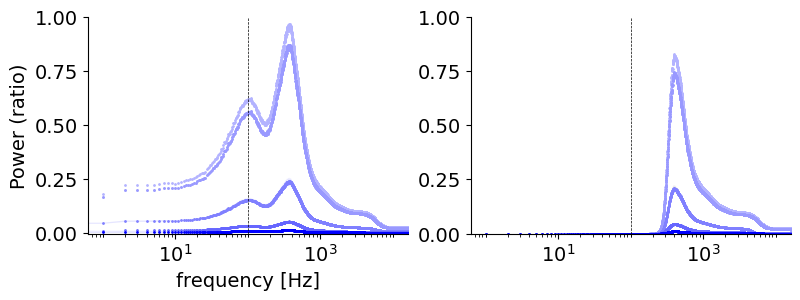

In [58]:
# takes 2 mins
YLIM_R = [-0.005, 1]
YLIM_P = [-0.001, 1]
N_MAJOR_TICKS = 4
SIZE = 1
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------

# VIVO

# in descending order
axes[0].plot(
    out_raw_gain_6x_fitd["freq"],
    psd_mean_raw_gain_6x_fitd,
    color=(0.8, 0.8, 1),
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="half fitted",
)
axes[0].plot(
    out_raw_gain_2["freq"],
    psd_mean_raw_gain_2,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=(0.7, 0.7, 1),
    label="raw",
)
axes[0].plot(
    out_raw_gain_4x_fitd["freq"],
    psd_mean_raw_gain_4x_fitd,
    color=(0.6, 0.6, 1),
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="half fitted",
)
axes[0].plot(
    out_raw["freq"],
    psd_mean_raw,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=(0.5, 0.5, 1),
    label="raw",
)

axes[0].plot(
    out_raw_ftd["freq"],
    psd_mean_raw_ftd,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=(0.4, 0.4, 1),
    label="fitted",
)
axes[0].plot(
    out_raw_half_ftd["freq"],
    psd_mean_raw_half_ftd,
    color=(0, 0, 1),
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="half fitted",
)

# confidence interval
axes[0].fill_between(
    out_raw["freq"],
    (psd_mean_raw - ci_raw),
    (psd_mean_raw + ci_raw),
    color=[0.5, 0.5, 1],
    linewidth=0,
    alpha=0.2,
)

axes[0].fill_between(
    out_raw_half_ftd["freq"],
    (psd_mean_raw_half_ftd - ci_raw_half_ftd),
    (psd_mean_raw_half_ftd + ci_raw_half_ftd),
    color=[0.5, 0.5, 1],
    linewidth=1,
    alpha=0.2,
)
axes[0].fill_between(
    out_raw_ftd["freq"],
    (psd_mean_raw_ftd - ci_raw_ftd),
    (psd_mean_raw_ftd + ci_raw_ftd),
    color=[0.5, 0.5, 1],
    linewidth=0,
    alpha=0.2,
)
# 100 Hz (LFP)
axes[0].vlines(
    x=100, ymin=YLIM_R[0], ymax=YLIM_R[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[0].set_xscale("log")
axes[0].set_xlim([0, SFREQ_BUCCI / 2])
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylim(YLIM_R)
axes[0].set_ylabel("Power (ratio)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[0].set_xticklabels([])

# Preprocessed panel ************************************************************
# *6, g=2, *4, g=1, /2, fitted
axes[1].plot(
    out_prep_gain_6x_fitd["freq"],
    psd_mean_prep_gain_6x_fitd,
    color=(0.8, 0.8, 1),
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="half fitted",
)
axes[1].plot(
    out_prep_gain_2["freq"],
    psd_mean_prep_gain_2,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=(0.7, 0.7, 1),
    label="prep",
)
axes[1].plot(
    out_prep_gain_4x_fitd["freq"],
    psd_mean_prep_gain_4x_fitd,
    color=(0.6, 0.6, 1),
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="half fitted",
)
axes[1].plot(
    out_prep["freq"],
    psd_mean_prep,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=(0.5, 0.5, 1),
    label="prep",
)

axes[1].plot(
    out_prep_ftd["freq"],
    psd_mean_prep_ftd,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=(0.4, 0.4, 1),
    label="fitted",
)
axes[1].plot(
    out_prep_half_ftd["freq"],
    psd_mean_prep_half_ftd,
    color=(0, 0, 1),
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="half fitted",
)

# confidence interval
axes[1].fill_between(
    out_prep["freq"],
    (psd_mean_prep - ci_prep),
    (psd_mean_prep + ci_prep),
    color=[0.6, 0.6, 0.6],
    linewidth=0,
    alpha=0.2,
)
axes[1].fill_between(
    out_prep_ftd["freq"],
    (psd_mean_prep_ftd - ci_prep_ftd),
    (psd_mean_prep_ftd + ci_prep_ftd),
    color=[0.6, 0.6, 0.6],
    linewidth=0,
    alpha=0.2,
)
axes[1].fill_between(
    out_prep_half_ftd["freq"],
    (psd_mean_prep_half_ftd - ci_prep_half_ftd),
    (psd_mean_prep_half_ftd + ci_prep_half_ftd),
    color=[0.5, 0.5, 1],
    linewidth=0,
    alpha=0.2,
)

# 100 Hz (LFP)
axes[1].vlines(
    x=100, ymin=YLIM_P[0], ymax=YLIM_P[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axes[1].set_ylim(YLIM_P)
axes[1].set_xlim([-1, SFREQ_BUCCI / 2])

fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[1].get_legend().remove()

# save (12MB figure)
plt.savefig(
    "figures/2_realism/4_power/svg/buccino/buccino_10m_psd_by_gain_raw_welch.svg",
    **savefig_cfg
)

Text(0, 0.5, 'Peak after preprocessing')

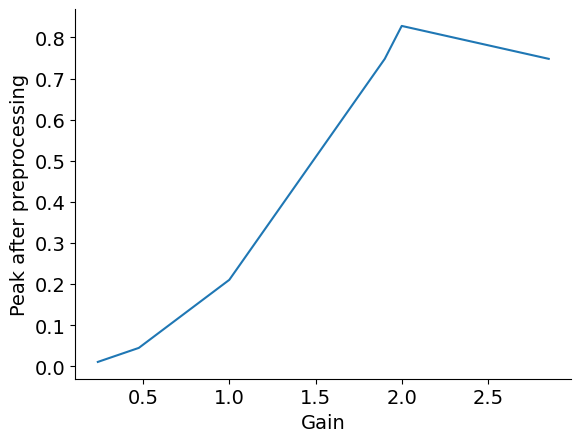

In [74]:
# get peaks
peak6x = max(psd_mean_prep_gain_6x_fitd[out_prep_gain_6x_fitd["freq"] > 100])
peak4x = max(psd_mean_prep_gain_4x_fitd[out_prep_gain_4x_fitd["freq"] > 100])
peak2 = max(psd_mean_prep_gain_2[out_prep_gain_2["freq"] > 100])
peak1 = max(psd_mean_prep[out_prep["freq"] > 100])
peakhalf = max(psd_mean_prep_half_ftd[out_prep_half_ftd["freq"] > 100])
peakftd = max(psd_mean_prep_ftd[out_prep_ftd["freq"] > 100])

plt.plot(
    [fitting_gain * 6, 2, fitting_gain * 4, 1, fitting_gain, fitting_gain / 2],
    [peak6x, peak2, peak4x, peak1, peakftd, peakhalf],
)
plt.xlabel("Gain")
plt.ylabel("Peak after preprocessing")

### Accuracies


[0.856, 0.884, 0.86]


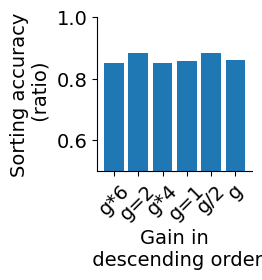

In [48]:
# *6, g=2, *4, raw, /2, fitted
# sorting extractors
Sorting6x = si.load_extractor(KS3_SORTING_GAIN_6X_FITD_PATH)
SortingG2 = si.load_extractor(KS3_SORTING_GAIN_2_PATH)
Sorting4x = si.load_extractor(KS3_SORTING_GAIN_4X_FITD_PATH)
Sorting = si.load_extractor(KS3_SORTING_PATH)
SortingHalfFtd = si.load_extractor(KS3_SORTING_HALF_FTD_PATH)
SortingFtd = si.load_extractor(KS3_SORTING_FTD_PATH)

# accuracies
acc6x = (
    get_sorting_accuracies(SORTING_TRUE_PATH, KS3_SORTING_GAIN_6X_FITD_PATH) >= 0.8
).mean()
accg2 = (
    get_sorting_accuracies(SORTING_TRUE_PATH, KS3_SORTING_GAIN_2_PATH) >= 0.8
).mean()
acc4x = (
    get_sorting_accuracies(SORTING_TRUE_PATH, KS3_SORTING_GAIN_4X_FITD_PATH) >= 0.8
).mean()
acc = (get_sorting_accuracies(SORTING_TRUE_PATH, KS3_SORTING_PATH) >= 0.8).mean()
acc_half_ftd = (
    get_sorting_accuracies(SORTING_TRUE_PATH, KS3_SORTING_HALF_FTD_PATH) >= 0.8
).mean()
acc_ftd = (
    get_sorting_accuracies(SORTING_TRUE_PATH, KS3_SORTING_FTD_PATH) >= 0.8
).mean()

# plot
fig, ax = plt.subplots(figsize=(2, 2))
xlabels = ["g*6", "g=2", "g*4", "g=1", "g/2", "g"]
ax.bar(xlabels, [acc6x, accg2, acc4x, acc, acc_half_ftd, acc_ftd])
ax.set_xticklabels(xlabels, rotation=45)
ax.set_xlabel("Gain in\n descending order")
ax.set_ylabel("Sorting accuracy\n (ratio)")
ax.set_ylim([0.5, 1])
print([acc, acc_half_ftd, acc_ftd])